# CLF-QP Controller
My notes about the CLF controller can be found in [this link](https://lopsided-sailfish-2df.notion.site/Lyapunov-Functions-and-Control-Barrier-Functions-232d71044bdf80989298d60b606f56b2).

## The System
The system modeled in this notebook is simply (a simple integrator):
$$
\dot{x} = u
$$

Which is a control affine system, where a control affine system is any system where:
$$
\dot{x} = f(x) + g(x)u
$$

## Recap of the Control Lyapunov Function (CLF)

The CLF is a function that must satisfy the following:

Given that you have a control affine system (defined above), we need a Lyapunov function that satisfies the following:


$$
V(x_e) = 0
$$
$$
V(x) > 0\ for\ x\neq x_e
$$
$$
\dot{V}(x, u) < 0\ for\ x \neq x_e 
$$

Assuming that our u is constant with time, and since our system is control affine, we can expand:
$$
\dot{V}(x) = \nabla V(x) \dot{x} = \nabla V(x) f(x) + \nabla V(x) g(x) u
$$

Hence we finally have the following constraint:

$$
\nabla V(x) f(x) + \nabla V(x) g(x) u < 0\ for\ x \neq x_e 
$$


## Defining the CLF for our system:

$$
V(x) = \frac{1}{2} x^2
$$

Taking the derivative:
$$
\dot{V}(x) = x\dot{x}=xu
$$

We also want to force V(x) to decay exponentially, so we define the following:
$$
\dot{V}(x)=xu \leq -cV(x)
$$

## Formulating the Quadratic-Program

We can then define the following quadratic program where:

$$
argmin ||u||
$$
Subject to the following constraint
$$
\dot{V}(x) + cV(x) \leq 0
$$
$$
xu + c \frac{1}{2}x^2 \leq 0
$$







In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [1]:
# Parameters
c = 1.0  # CLF decay rate
T = 5.0
dt = 0.05
N = int(T / dt)
x = 5.0  # initial state


xs = [x]
us = []

In [3]:
for _ in range(N):
    # Define optimization variable
    u = cp.Variable()

    # Define CLF constraint: x*u + (c/2)x^2 <= 0
    V = 0.5 * x**2
    V_dot = x * u
    clf_constraint = V_dot + (c/2) * x**2 <= 0

    # Solve QP: minimize u^2 subject to CLF constraint
    prob = cp.Problem(cp.Minimize(cp.square(u)), [clf_constraint])
    prob.solve()

    # Apply control
    u_val = u.value
    us.append(u_val)
    x += u_val * dt
    xs.append(x)

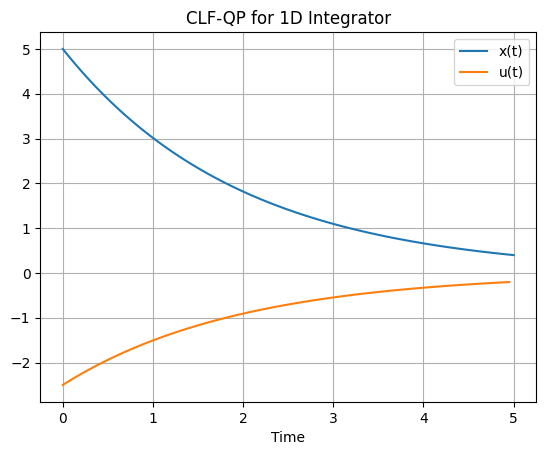

In [4]:
# Plotting
ts = np.linspace(0, T, N+1)
plt.plot(ts, xs, label="x(t)")
plt.plot(ts[:-1], us, label="u(t)")
plt.xlabel("Time")
plt.legend()
plt.title("CLF-QP for 1D Integrator")
plt.grid()
plt.show()

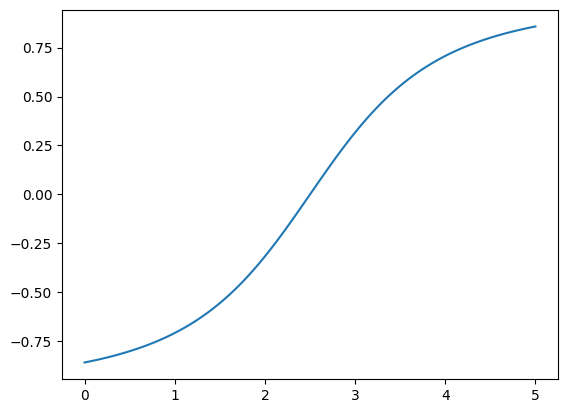

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Simulation parameters
dt = 0.1
T = 200

# Goal
xg, yg = 5.0, 5.0

# CLF/CBF parameters
c1 = 2.0
c2 = 2.0
p_delta = 1000.0
R = np.diag([1.0, 0.1])  # Prefer turning over fast driving

# Obstacle parameters
ox, oy, r = 2.5, 2.5, 1.0

def make_sdf(x, y):
    dx = x - ox
    dy = y - oy
    d = np.sqrt(dx**2 + dy**2) - r
    # h = d / np.sqrt(1 + d**2)
    return d

def grad_sdf(x, y):
    dsdf_dx = (x - ox) / np.sqrt((x - ox)**2 + (y - oy)**2)
    dsdf_dy = (y - oy) / np.sqrt((x - ox)**2 + (y - oy)**2)
    return np.array([dsdf_dx, dsdf_dy])

x_v = []
d_v = []
grad_x = []
grad_y = []
for x in np.linspace(0, 5.0, 100):
    y = 1.0
    x_v.append(x)
    d_v.append(make_sdf(x, y))
    gx, gy = grad_sdf(x, y)
    grad_x.append(gx)
    grad_y.append(gy)

plt.plot(x_v, grad_x)
# plt.plot(x_v, d_v)

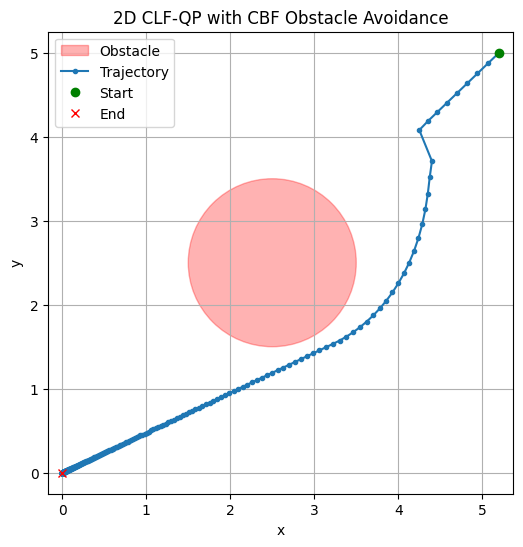

In [38]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 1000
dt = 0.1
c = 0.5       # CLF rate
alpha = 1.0   # CBF rate
delta_relaxation = 0.0

# Obstacle parameters
ox, oy, r = 2.5, 2.5, 1.0

def make_sdf(x, y):
    dx = x - ox
    dy = y - oy
    return np.sqrt(dx**2 + dy**2) - r

def grad_sdf(x, y):
    norm = np.sqrt((x - ox)**2 + (y - oy)**2)
    return np.array([(x - ox) / norm, (y - oy) / norm])

# Initial state
x, y = 5.2, 5.0
xs, ys = [x], [y]
us = []

for _ in range(N):
    # Control input
    u = cp.Variable(2)

    # CLF constraint
    V = 0.5 * (x**2 + y**2)
    V_dot = x * u[0] + y * u[1]
    clf_constraint = V_dot + (c / 2) * (x**2 + y**2) <= delta_relaxation

    # CBF constraint
    h = make_sdf(x, y)
    grad_h = grad_sdf(x, y)
    h_dot = grad_h @ u
    cbf_constraint = h_dot + alpha * h >= 0

    # Optimization problem
    cost = cp.sum_squares(u) + delta_relaxation**2
    prob = cp.Problem(cp.Minimize(cost), [clf_constraint, cbf_constraint])
    prob.solve()

    # Apply control
    u_val = u.value
    us.append(u_val)
    x += u_val[0] * dt
    y += u_val[1] * dt
    xs.append(x)
    ys.append(y)

# Plot the trajectory
xs = np.array(xs)
ys = np.array(ys)

circle = plt.Circle((ox, oy), r, color='r', alpha=0.3, label='Obstacle')

plt.figure(figsize=(6, 6))
plt.gca().add_patch(circle)
plt.plot(xs, ys, marker='o', markersize=3, label="Trajectory")
plt.plot(xs[0], ys[0], 'go', label='Start')
plt.plot(xs[-1], ys[-1], 'rx', label='End')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D CLF-QP with CBF Obstacle Avoidance')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


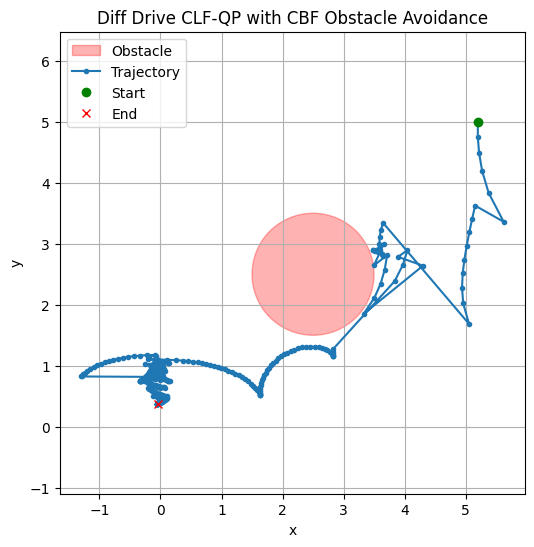

In [43]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 300
dt = 0.1
c = 0.5       # CLF rate
alpha = 1.0   # CBF rate
delta_relaxation = 0.0
k_theta = 1.0  # weight for heading error

# Obstacle parameters
ox, oy, r = 2.5, 2.5, 1.0

def make_sdf(x, y):
    dx = x - ox
    dy = y - oy
    return np.sqrt(dx**2 + dy**2) - r

def grad_sdf(x, y):
    norm = np.sqrt((x - ox)**2 + (y - oy)**2)
    return np.array([(x - ox) / norm, (y - oy) / norm])

# Initial state
x, y, theta = 5.2, 5.0, -np.pi/2.0  # Heading toward origin
xs, ys, thetas = [x], [y], [theta]
us = []

for _ in range(N):
    u = cp.Variable(2)  # [v, omega]
    v = u[0]
    omega = u[1]

    # CLF with heading
    V = 0.5 * (x**2 + y**2 + k_theta * theta**2)
    V_dot = x * v * np.cos(theta) + y * v * np.sin(theta) + k_theta * theta * omega
    clf_constraint = V_dot + c * V <= delta_relaxation

    # CBF stays the same
    h = make_sdf(x, y)
    grad_h = grad_sdf(x, y)
    h_dot = grad_h[0] * u[0] * np.cos(theta) + grad_h[0] * u[1] * np.sin(theta) +  grad_h[0] * v * np.cos(theta) + grad_h[1] * v * np.sin(theta)
    cbf_constraint = h_dot + alpha * h >= 0

    cost = cp.sum_squares(u)
    prob = cp.Problem(cp.Minimize(cost), [clf_constraint, cbf_constraint])
    prob.solve()

    if u.value is None:
        print("Solver failed!")
        break

    v_val, omega_val = u.value
    us.append([v_val, omega_val])
    x += v_val * np.cos(theta) * dt
    y += v_val * np.sin(theta) * dt
    theta += omega_val * dt

    xs.append(x)
    ys.append(y)
    thetas.append(theta)

# Plotting
xs = np.array(xs)
ys = np.array(ys)

circle = plt.Circle((ox, oy), r, color='r', alpha=0.3, label='Obstacle')

plt.figure(figsize=(6, 6))
plt.gca().add_patch(circle)
plt.plot(xs, ys, marker='o', markersize=3, label="Trajectory")
plt.plot(xs[0], ys[0], 'go', label='Start')
plt.plot(xs[-1], ys[-1], 'rx', label='End')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Diff Drive CLF-QP with CBF Obstacle Avoidance')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()


/usr/local/lib/python3.11/site-packages/scs/__init__.py:83: UserWarning: Converting A to a CSC (compressed sparse column) matrix; may take a while.
  warn(
/usr/local/lib/python3.11/site-packages/scs/__init__.py:113: UserWarning: Converting P to a CSC (compressed sparse column) matrix; may take a while.
  warn(


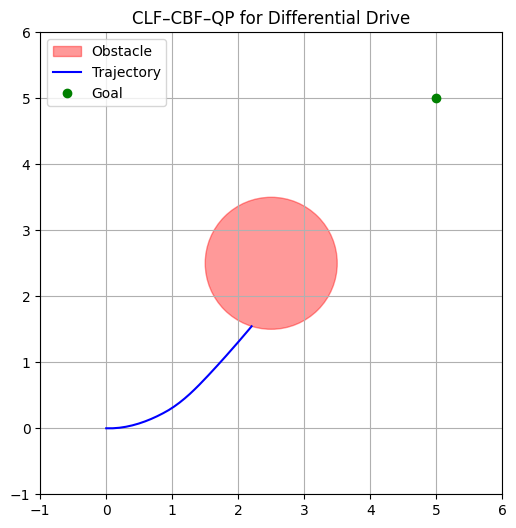

In [ ]:
# Initialize trajectory
xs = np.zeros((T+1, 3))
xs[0] = np.array([0.0, 0.0, 0.0])

for t in range(T):
    x, y, theta = xs[t]

    # -------- CLF 1: Position tracking --------
    V_pos = (x - xg)**2 + (y - yg)**2
    dVdx = 2 * (x - xg)
    dVdy = 2 * (y - yg)
    LgV_pos = np.array([
        dVdx * np.cos(theta) + dVdy * np.sin(theta),  # v
        0.0                                           # omega
    ])
    LfV_pos = 0.0

    # -------- CLF 2: Heading tracking --------
    goal_theta = np.arctan2(yg - y, xg - x)
    theta_err = np.arctan2(np.sin(goal_theta - theta), np.cos(goal_theta - theta))
    V_theta = theta_err**2
    LgV_theta = np.array([0.0, -2 * theta_err])
    LfV_theta = 0.0

    # -------- CBF: Obstacle avoidance --------
    h = make_sdf(x, y)
    grad_h = grad_sdf(x, y)
    Lfh = 0.0
    Lgh = np.array([grad_h.dot([np.cos(theta), np.sin(theta)]), 0.0])

    # -------- Define QP --------
    u = cp.Variable(2)
    delta1 = cp.Variable(nonneg=True)  # for position CLF
    delta2 = cp.Variable(nonneg=True)  # for heading CLF

    constraints = [
        # CLF 1
        LfV_pos + LgV_pos @ u + c1 * V_pos <= delta1,
        # CLF 2
        LfV_theta + LgV_theta @ u + c1 * V_theta <= delta2,
        # CBF
        Lfh + Lgh @ u + c2 * h >= 0,
        # Input bounds
        u[0] >= -1.0, u[0] <= 1.0,
        u[1] >= -2.0, u[1] <= 2.0
    ]

    cost = cp.quad_form(u, R) + p_delta * (cp.square(delta1) + cp.square(delta2))
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.SCS)

    if u.value is None:
        print(f"Solver failed at step {t}")
        u_val = np.zeros(2)
    else:
        u_val = u.value

    # -------- Simulate robot --------
    v, omega = u_val
    x_next = x + dt * v * np.cos(theta)
    y_next = y + dt * v * np.sin(theta)
    theta_next = theta + dt * omega
    theta_next = np.arctan2(np.sin(theta_next), np.cos(theta_next))  # normalize

    xs[t+1] = [x_next, y_next, theta_next]

# -------- Visualization --------
fig, ax = plt.subplots(figsize=(6, 6))
ax.add_patch(plt.Circle((ox, oy), r, color='r', alpha=0.4, label='Obstacle'))
ax.plot(xs[:, 0], xs[:, 1], 'b-', label='Trajectory')
ax.plot(xg, yg, 'go', label='Goal')
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 6)
ax.set_aspect('equal')
ax.set_title('CLF–CBF–QP for Differential Drive')
ax.legend()
plt.grid(True)
plt.show()